In [2]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import zipfile
import seaborn as sns
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot
from keras.utils.vis_utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report

# set seed to reproduce similar results
np.random.seed(0)

In [3]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values
 
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded
 
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + './human+activity+recognition+using+smartphones/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + './human+activity+recognition+using+smartphones/UCI HAR Dataset/')
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print("trainX shape: ",trainX.shape)
    print("trainy shape: ", trainy.shape)
    print("testX shape: ", testX.shape)
    print("testy shape: ", testy.shape)
    return trainX, trainy, testX, testy

In [4]:
trainX, trainy, testX, testy = load_dataset()

trainX shape:  (7352, 128, 9)
trainy shape:  (7352, 6)
testX shape:  (2947, 128, 9)
testy shape:  (2947, 6)


In [5]:
# Helper function to plot distribution of the features
def plot_distributions(trainX):
	# remove overlap
	cut = int(trainX.shape[1] / 2)
	longX = trainX[:, -cut:, :]
	# flatten windows
	longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
	print(longX.shape)
	pyplot.figure()
	xaxis = None
	for i in range(longX.shape[1]):
		ax = pyplot.subplot(longX.shape[1], 1, i+1, sharex=xaxis)
		ax.set_xlim(-1, 1)
		if i == 0:
			xaxis = ax
		pyplot.hist(longX[:, i], bins=100)
	pyplot.show()

(470528, 9)


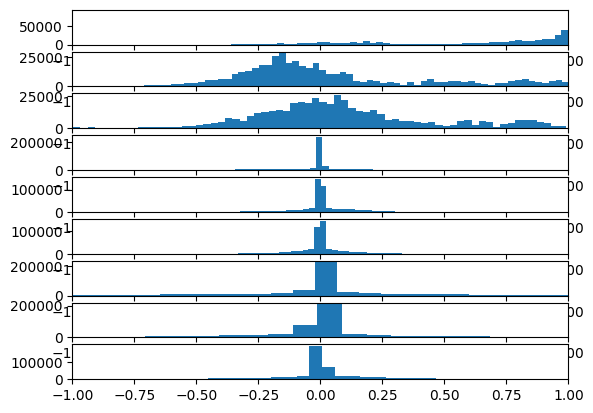

In [6]:
# plot distributions
plot_distributions(trainX)

In [7]:
## set number of epochs and batch size
batch_size = 64
validation_split = 0.2

In [8]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] #/np.sum(cm[x,:])

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
classNames=["WALKING","WALKING_UPSTAIRS","WALKING_DOWNSTAIRS","SITTING","STANDING","LAYING"]

In [9]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
# 모델 초기화
model1 = Sequential()

# CNN 레이어
model1.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)))
model1.add(MaxPooling1D(pool_size=2))

# LSTM 레이어
model1.add(LSTM(100, input_shape=(n_timesteps,n_features)))  # return_sequences=True로 설정하여 모든 시간 단계의 출력을 반환

# Flatten 레이어
model1.add(Flatten())

# 출력 Dense 레이어
model1.add(Dense(n_outputs, activation='softmax'))

# 모델 컴파일
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [10]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 126, 64)           1792      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 63, 64)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 100)               66000     
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 6)                 606       
                                                                 
Total params: 68,398
Trainable params: 68,398
Non-trainable params: 0
____________________________________________________

In [11]:
# fit network
train_epochs = 10
history1 = model1.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/10
92/92 [==============================] - 11s 95ms/step - loss: 0.8906 - accuracy: 0.6300 - val_loss: 0.7753 - val_accuracy: 0.6499
Epoch 2/10
92/92 [==============================] - 8s 86ms/step - loss: 0.4986 - accuracy: 0.7941 - val_loss: 0.5860 - val_accuracy: 0.8022
Epoch 3/10
92/92 [==============================] - 9s 93ms/step - loss: 0.3589 - accuracy: 0.8698 - val_loss: 0.5250 - val_accuracy: 0.8525
Epoch 4/10
92/92 [==============================] - 8s 90ms/step - loss: 0.2261 - accuracy: 0.9196 - val_loss: 0.4495 - val_accuracy: 0.8906
Epoch 5/10
92/92 [==============================] - 9s 96ms/step - loss: 0.1721 - accuracy: 0.9361 - val_loss: 0.4159 - val_accuracy: 0.8994
Epoch 6/10
92/92 [==============================] - 8s 90ms/step - loss: 0.1477 - accuracy: 0.9441 - val_loss: 0.4122 - val_accuracy: 0.9035
Epoch 7/10
92/92 [==============================] - 9s 98ms/step - loss: 0.1443 - accuracy: 0.9434 - val_loss: 0.4274 - val_accuracy: 0.9014
Epoch 8/10
9

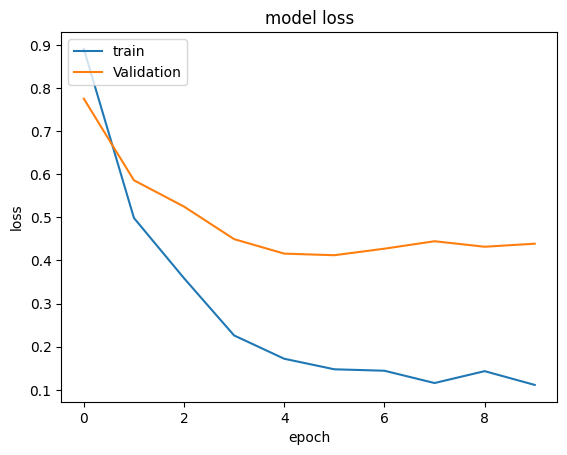

In [12]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [13]:
# evaluate model
test_loss, test_accuracy = model1.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the CNN+LSTM model", test_accuracy)
predictions = model1.predict(testX)

Accuracy of the CNN+LSTM model 0.8859857320785522
93/93 [==============================] - 3s 22ms/step
